Information Planck Constant Sweep in Historical Fidelity Simulator

This script explores the role of the information Planck constant (ℏ_h):
1. Impact on fidelity and uncertainty bounds
2. Scaling behavior in classical and quantum regimes
3. GPU-accelerated parameter sweeps for efficient exploration
4. Comparison of classical and quantum responses

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from typing import Dict, List, Tuple, Any

from historical_fidelity_simulator.simulator import GeneralizedHistoricalSimulator, SimulationMode

### def setup_output_directory() -> Path:

Set up output directory for saving results.
    
    Returns:
        Path: Path to output directory
    

In [2]:
def setup_output_directory() -> Path:
    # Try different relative paths to find the output directory
    output_dir = Path('output')
    if not output_dir.exists():
        # If running from examples directory, go up one level
        output_dir = Path('..') / 'output'
    if not output_dir.exists():
        # If running from a subdirectory of examples, go up two levels
        output_dir = Path('../..') / 'output'
    
    # Create the output directory if it doesn't exist
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create a subdirectory for information Planck sweep results
    sweep_dir = output_dir / 'information_planck_sweep'
    sweep_dir.mkdir(exist_ok=True)
    
    print(f"Saving results to: {sweep_dir.absolute()}")
    return sweep_dir

In [3]:
def run_sweep_for_mode(
    hbar_h_range: np.ndarray,
    params: Dict[str, Any],
    mode: SimulationMode,
    n_steps: int,
    measure_interval: int
) -> Tuple[List[float], List[float]]:
    """Run information Planck constant sweep for given mode.
    
    Args:
        hbar_h_range: Array of ℏ_h values to sweep
        params: Dictionary of simulation parameters
        mode: Simulation mode (classical or quantum)
        n_steps: Number of simulation steps
        measure_interval: Interval between measurements
        
    Returns:
        Tuple of (fidelities, bounds) lists
    """
    fidelities = []
    bounds = []
    
    for h in tqdm(hbar_h_range, desc=f"{mode.value} mode"):
        sim = GeneralizedHistoricalSimulator(
            n_sites=params['n_sites_classical' if mode == SimulationMode.CLASSICAL else 'n_sites_quantum'],
            coupling_strength=params['J'],
            field_strength=params['h'],
            temperature=params['T'],
            hbar_h=h,
            mode=mode,
            use_gpu=(mode == SimulationMode.QUANTUM)
        )
        
        results = sim.run_simulation(
            n_steps=n_steps,
            dt=params['dt'],
            measure_interval=measure_interval
        )
        
        fidelities.append(results[-1]['fidelity'])
        bounds.append(results[-1]['bound'])
    
    return fidelities, bounds

In [4]:
def compute_phase_diagram(
    params: Dict[str, Any],
    T_range: np.ndarray,
    hbar_h_range: np.ndarray,
    mode: SimulationMode,
    results_cache: Dict[Tuple[float, float], float] = None
) -> np.ndarray:
    """Compute phase diagram for given mode.
    
    Args:
        params: Dictionary of simulation parameters
        T_range: Array of temperatures
        hbar_h_range: Array of ℏ_h values
        mode: Simulation mode (CLASSICAL or QUANTUM)
        results_cache: Optional cache of previous results
    
    Returns:
        2D array of fidelity values
    """
    n_sites = params['n_sites_classical' if mode == SimulationMode.CLASSICAL else 'n_sites_quantum']
    n_steps = params['n_steps_classical' if mode == SimulationMode.CLASSICAL else 'n_steps_quantum']
    measure_interval = 50 if mode == SimulationMode.CLASSICAL else 5
    
    grid = np.zeros((len(hbar_h_range), len(T_range)))
    
    for i, h in enumerate(tqdm(hbar_h_range, desc=f"{mode.name.title()} mode")):
        for j, T in enumerate(T_range):
            # Check cache first if available
            if results_cache is not None and (h, T) in results_cache:
                grid[i, j] = results_cache[(h, T)]
                continue
            
            sim = GeneralizedHistoricalSimulator(
                n_sites=n_sites,
                coupling_strength=params['J'],
                field_strength=params['h'],
                temperature=T,
                hbar_h=h,
                mode=mode,
                use_gpu=(mode == SimulationMode.QUANTUM)
            )
            
            results = sim.run_simulation(
                n_steps=n_steps,
                dt=params['dt'],
                measure_interval=measure_interval
            )
            
            fidelity = results[-1]['fidelity']
            grid[i, j] = fidelity
            
            # Cache the result if cache is available
            if results_cache is not None:
                results_cache[(h, T)] = fidelity
    
    return grid

In [5]:
def plot_sweep_results(
    hbar_h_range: np.ndarray,
    classical_data: Tuple[List[float], List[float]],
    quantum_data: Tuple[List[float], List[float]],
    params: Dict[str, Any],
    output_dir: Path
) -> None:
    """Plot and save sweep results.
    
    Args:
        hbar_h_range: Array of ℏ_h values
        classical_data: Tuple of classical (fidelities, bounds)
        quantum_data: Tuple of quantum (fidelities, bounds)
        params: Simulation parameters
        output_dir: Directory to save plots
    """
    classical_fidelities, classical_bounds = classical_data
    quantum_fidelities, quantum_bounds = quantum_data
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.semilogx(hbar_h_range, classical_fidelities, 'o-', label=f'Classical (N={params["n_sites_classical"]})')
    plt.semilogx(hbar_h_range, quantum_fidelities, 's-', label=f'Quantum (N={params["n_sites_quantum"]})')
    plt.xlabel('Information Planck Constant (ℏ_h)')
    plt.ylabel('Fidelity')
    plt.title('Fidelity vs ℏ_h')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.loglog(hbar_h_range, classical_bounds, 'o-', label=f'Classical (N={params["n_sites_classical"]})')
    plt.loglog(hbar_h_range, quantum_bounds, 's-', label=f'Quantum (N={params["n_sites_quantum"]})')
    plt.xlabel('Information Planck Constant (ℏ_h)')
    plt.ylabel('ℏ_h Bound')
    plt.title('Generalized Bound vs ℏ_h')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(output_dir / 'information_planck_sweep.png')
    plt.show()

In [6]:
def plot_phase_diagrams(
    T_grid: np.ndarray,
    hbar_h_grid: np.ndarray,
    classical_grid: np.ndarray,
    quantum_grid: np.ndarray,
    params: Dict[str, Any],
    output_dir: Path
) -> None:
    """Plot and save phase diagrams.
    
    Args:
        T_grid: 2D array of temperatures
        hbar_h_grid: 2D array of ℏ_h values
        classical_grid: Classical fidelity values
        quantum_grid: Quantum fidelity values
        params: Simulation parameters
        output_dir: Directory to save plots
    """
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(T_grid, hbar_h_grid, classical_grid, shading='auto')
    plt.colorbar(label='Fidelity')
    plt.xlabel('Temperature (T)')
    plt.ylabel('Information Planck Constant (ℏ_h)')
    plt.title(f'Classical Phase Diagram (N={params["n_sites_classical"]})')
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    plt.pcolormesh(T_grid, hbar_h_grid, quantum_grid, shading='auto')
    plt.colorbar(label='Fidelity')
    plt.xlabel('Temperature (T)')
    plt.ylabel('Information Planck Constant (ℏ_h)')
    plt.title(f'Quantum Phase Diagram (N={params["n_sites_quantum"]})')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig(output_dir / 'information_planck_phase_diagram.png')
    plt.show()

In [7]:
def main() -> None:
    # System parameters
    params = {
        'n_sites_classical': 32,  # Larger system for classical
        'n_sites_quantum': 8,     # Smaller system for quantum (2^8 states)
        'J': 1.0,                 # Coupling strength
        'h': 0.1,                 # Field strength
        'T': 2.0,                 # Temperature
        'n_steps_classical': 2000, # More steps for better statistics
        'n_steps_quantum': 200,    # Fewer steps for quantum
        'dt': 0.05                # Time step
    }
    
    # Setup sweep parameters
    hbar_h_range = np.logspace(-3, 1, 20)  # Log scale from 0.001 to 10
    T_range = np.linspace(0.1, 5.0, 15)    # Temperature range for phase diagram
    hbar_h_range_2d = np.logspace(-3, 1, 15)  # Log scale for phase diagram
    T_grid, hbar_h_grid = np.meshgrid(T_range, hbar_h_range_2d)
    
    # Set up output directory
    output_dir = setup_output_directory()
    
    # Run information Planck constant sweeps
    print("\nRunning information Planck constant sweeps...")
    classical_data = run_sweep_for_mode(hbar_h_range, params, SimulationMode.CLASSICAL, params['n_steps_classical'], 50)
    quantum_data = run_sweep_for_mode(hbar_h_range, params, SimulationMode.QUANTUM, params['n_steps_quantum'], 5)
    
    # Plot sweep results
    plot_sweep_results(hbar_h_range, classical_data, quantum_data, params, output_dir)
    
    # Initialize results cache for quantum mode (to avoid recomputing)
    quantum_results_cache = {}
    
    # Generate phase diagrams
    print("\nGenerating phase diagrams...")
    classical_grid = compute_phase_diagram(params, T_range, hbar_h_range_2d, SimulationMode.CLASSICAL)
    quantum_grid = compute_phase_diagram(params, T_range, hbar_h_range_2d, SimulationMode.QUANTUM, quantum_results_cache)
    
    # Plot phase diagrams
    plot_phase_diagrams(T_grid, hbar_h_grid, classical_grid, quantum_grid, params, output_dir)
    
    print("\nResults saved to:")
    print(f"- {(output_dir / 'information_planck_sweep.png').absolute()}")
    print(f"- {(output_dir / 'information_planck_phase_diagram.png').absolute()}")

Saving results to: d:\PyProjects\historical-fidelity-simulator\examples\notebooks\02_parameter_sweeps\..\..\output\information_planck_sweep

Running information Planck constant sweeps...


quantum mode: 100%|██████████| 20/20 [00:33<00:00,  1.70s/it]


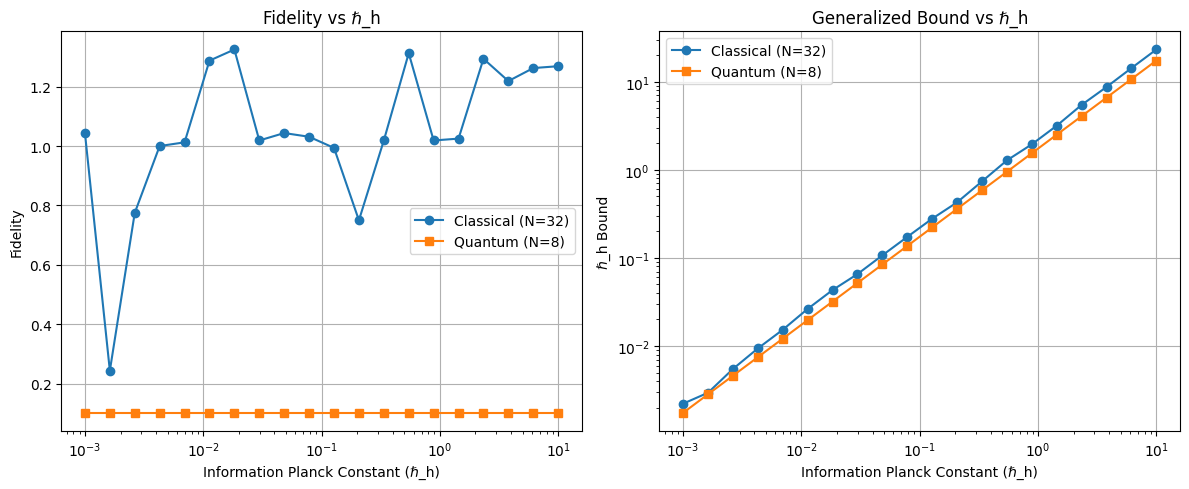


Generating phase diagrams...


Quantum mode:  33%|███▎      | 5/15 [02:37<05:15, 31.59s/it]


KeyboardInterrupt: 

In [8]:
# Run the main function
main()